In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time
import datetime

from tqdm import tqdm 
from scipy import stats
from matplotlib.dates import date2num
pd.options.mode.chained_assignment = None
PATH = "C:/Users/jackl/OneDrive/Documents/finance_research/japan_qe/"

In [2]:
def change_orientation(df):
    # modifies orientation list
    # makes individual owners marked as passive
    o_list, h_list = list(df['orientation']), list(df['holder_type'])
    mod_o_list = []
    for i in range(len(o_list)):
        o, h = o_list[i], h_list[i]

        if o == 'Active':
            o = 'Active Informed'

        if h == 'VC/PE Firm': 
            mod_o_list.append('Active Informed')
        else: 
            mod_o_list.append(o)

    df['mod_orientation'] = mod_o_list
    return df

def get_good_coverage(own_share_df):
    #remove outliers likely due to bad coverage
    sedol_df_list = []
    for sedol, sedol_df in tqdm(own_share_df.groupby(['sedol'])): 
        sedol_df = sedol_df.reset_index(drop=True)
        z_score_df = abs(sedol_df[sedol_df.columns[2:]].apply(stats.zscore, nan_policy='omit'))
        good_index = z_score_df[((z_score_df['inf_share_no_ff'] < 2.5) & (z_score_df['pass_share_no_ff'] < 2.5))].index
        bad_index = z_score_df[~((z_score_df['inf_share_no_ff'] < 2.5) & (z_score_df['pass_share_no_ff'] < 2.5))].index

        good_df = sedol_df.iloc[good_index]
        bad_df = sedol_df.iloc[bad_index]
        bad_df[bad_df.columns[-3:]] = math.nan
        sedol_df = pd.concat([good_df, bad_df])
        sedol_df_list.append(sedol_df)

    own_share_df = pd.concat(sedol_df_list)
    return own_share_df

#get turnover for active
def get_chars_df(own_df1):
    date_list = []
    sedol_list = []
    
    turnover_list = []
    gv_list = []
    hy_list = []
    
    for [sedol, date], date_df in tqdm(own_df1.groupby(['sedol', 'asof_date'])): 
        date_list.append(date)
        sedol_list.append(sedol)
        
        active_df = date_df[date_df['mod_orientation']=='Active Informed']
        
        #turnover
        try:
            turnover_pct_df = active_df[['holdings', 'turnover_pct']].dropna()
            turnover_av = np.average(turnover_pct_df['turnover_pct'], weights=turnover_pct_df['holdings'])
        except: 
            turnover_av = math.nan
        turnover_list.append(turnover_av)

        #growth vs value
        try:
            gv_df = active_df[['holdings', 'gv_scale']].dropna()
            gv_av = np.average(gv_df['gv_scale'], weights=gv_df['holdings'])
        except: 
            gv_av = math.nan
        gv_list.append(gv_av)
        
        try:
            hy_df = active_df[['holdings', 'hy_scale']].dropna()
            hy_av = np.average(hy_df['hy_scale'], weights=hy_df['holdings'])
        except: 
            hy_av = math.nan
        hy_list.append(hy_av)
        
    chars_df = pd.DataFrame({
                             'asof_date': date_list, 
                             'sedol': sedol_list, 
                             'inf_turnover': turnover_list, 
                             'inf_gv': gv_list, 
                             'inf_hy': hy_list
                            })    
    return chars_df

# GET VALUES FOR EACH TYPE OF INVESTOR
def get_breakdown(df):
    df = df[~(df['short_dummy']==1)]
    own_share_list = []
    for sedol, sedol_df in tqdm(df.groupby(['sedol'])):
        try: 
            breakdown_df = sedol_df.groupby(['mod_orientation', 'asof_date']).sum()[['pct']].reset_index()

            uninf_df = (100 - breakdown_df.groupby(['asof_date']).sum()[['pct']]).reset_index()
            inf_df = breakdown_df[breakdown_df['mod_orientation']=='Active Informed'][['asof_date', 'pct']]
            pass_df = breakdown_df[breakdown_df['mod_orientation']=='Passive'][['asof_date', 'pct']]

            uninf_df.columns = ['asof_date', 'uninf_share_no_ff']
            inf_df.columns = ['asof_date', 'inf_share_no_ff']
            pass_df.columns = ['asof_date', 'pass_share_no_ff']

            date_df = pd.DataFrame({'asof_date': date_list})
            date_df['sedol'] = sedol
            pt1 = pd.merge(date_df, inf_df, on=['asof_date'], how='left')
            pt2 = pd.merge(pt1, uninf_df, on=['asof_date'], how='left')
            sedol_df_shares = pd.merge(pt2, pass_df, on=['asof_date'], how='left')
            
            own_share_list.append(sedol_df_shares)
        except Exception as e: 
            print(sedol)
            print(e)
            
    return pd.concat(own_share_list)

def get_short_df(df): 
    #restrict to short only
    df = df[(df['short_dummy']==1) & 
            (df['mod_orientation']=='Active Informed')]
    
    pct_list = []
    sedol_list = []
    date_list = []

    for [sedol, date], df_subset in tqdm(df.groupby(['sedol', 'asof_date'])): 
        pct = df_subset['pct'].sum()
        pct_list.append(pct)
        sedol_list.append(sedol)
        date_list.append(date)

    short_df = pd.DataFrame({'sedol': sedol_list, 
                             'asof_date': date_list, 
                             'short_int': pct_list})
    
    return short_df

def get_num_invs(df):     
    sedol_list = []
    date_list = []
    num_passive_list = []
    num_inf_list = []
    
    conc_inf_list_first = []
    conc_total_list_first = []
    
    conc_inf_list_second = []
    conc_total_list_second = []
    
    
    for [sedol, date], df_subset in tqdm(df.groupby(['sedol', 'asof_date'])): 
        inf_df = df_subset[(df_subset['mod_orientation']=='Active Informed') & 
                           (df_subset['short_dummy']!=1)].sort_values(['pct'], ascending=False)
        total_df = df_subset.sort_values(['pct'], ascending=False)
            
        num_inf_list.append(len(inf_df.drop_duplicates(subset=['ciq'])))
        
        conc_inf_list_first.append(inf_df['pct'].head(10).sum())
        conc_total_list_first.append(total_df['pct'].head(10).sum())
        
        conc_inf_list_second.append(inf_df['pct'].head(30).sum())
        conc_total_list_second.append(total_df['pct'].head(30).sum())
        
        sedol_list.append(sedol)
        date_list.append(date)

    num_df = pd.DataFrame({'sedol': sedol_list, 
                           'asof_date': date_list, 
                           'num_inf': num_inf_list, 
                           'conc_inf_5': conc_inf_list_first, 
                           'conc_total_5': conc_total_list_first, 
                           'conc_inf_20': conc_inf_list_second, 
                           'conc_total_20': conc_total_list_second
                            })
    
    return num_df

##### Ownership Data

In [3]:
own_df1 = pd.read_pickle(PATH+'checkpoint_data/ownership_jan03_v2.pkl')
own_df1 = own_df1[(own_df1['asof_date'] >= pd.to_datetime('2010-09-01'))& 
                  (own_df1['asof_date'] <= pd.to_datetime('2021-01-01'))]
date_list = sorted(list(set(own_df1['asof_date'])))

In [4]:
nk_df = pd.read_csv(PATH+'nk_df_v2.csv')
sedol_list = list(nk_df['sedol'])

##### BOJ Purchase Data

In [32]:
boj_df = pd.read_pickle(PATH+'checkpoint_data/boj_purchases_stock_level_v2.pkl')

In [33]:
boj_df = boj_df[boj_df['sedol'].isin(sedol_list)].sort_values(['sedol', 'date'])

In [49]:
boj_df['date'] = boj_df['date'].replace({pd.to_datetime('2010-12-14'): pd.to_datetime('2010-09-30')})

##### Controls

In [8]:
control_df = pd.read_pickle(PATH+'checkpoint_data/controls_daily.pkl')

In [9]:
#quarterly data
control_df = control_df.sort_values(['sedol', 'datadate']).drop_duplicates(['sedol', 'yr_qtr_index'], keep='first')

# Get Ownership Share Regressions

In [89]:
own_share_df = get_breakdown(own_df1)
own_share_df = get_good_coverage(own_share_df)

100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:04<00:00, 49.78it/s]


In [90]:
short_df = get_short_df(own_df1)
own_share_df = pd.merge(own_share_df, 
                        short_df, 
                        on=['sedol', 'asof_date'], 
                        how='left')
own_share_df['short_int'] = own_share_df['short_int'].apply(lambda x: 0 if math.isnan(x)==True else x)

100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:04<00:00, 1412.25it/s]


In [91]:
# num_df = get_num_invs(own_df1)
# num_df.to_pickle(PATH+'checkpoint_data/num_funds.pkl')
num_df = pd.read_pickle(PATH+'checkpoint_data/num_funds.pkl')
own_share_df = pd.merge(own_share_df, 
                        num_df, 
                        on=['sedol', 'asof_date'], 
                        how='left')

own_share_df['conc_inf_5_rel'] = own_share_df['conc_inf_5']/own_share_df['inf_share_no_ff'] * 100
own_share_df['conc_inf_20_rel'] = own_share_df['conc_inf_20']/own_share_df['inf_share_no_ff'] * 100

In [92]:
own_share_df = pd.merge_asof(own_share_df.sort_values('asof_date'), 
                             boj_df[['sedol', 'date', 'boj_share_shares', 'boj_share_shares_no_ff', 'sic_2d']].sort_values('date'), 
                             by='sedol',
                             left_on=['asof_date'], 
                             right_on=['date'],
                             direction='backward').drop(columns='date').sort_values(['sedol', 'asof_date'])

In [98]:
own_share_df['yr_qtr_index'] = own_share_df['asof_date'].apply(lambda x: (x.year, math.ceil(x.month // 3)))
own_share_df['asof_date'] = own_share_df['asof_date'].apply(lambda x: pd.to_datetime('2010-10-01') if x==pd.to_datetime('2010-09-30') else x)
own_share_df = pd.merge(own_share_df, 
                        control_df, 
                        on=['sedol', 'yr_qtr_index'], 
                        how='left').sort_values(['sedol', 'asof_date'])

In [102]:
qtr_dict = dict(zip(sorted(set(own_share_df['asof_date'])), range(len(own_share_df['asof_date'].unique()))))
own_share_df['qtr'] = own_share_df['asof_date'].apply(lambda x: qtr_dict[x])
own_share_df['act_qtr'] = own_share_df['asof_date'].dt.month

In [103]:
own_share_df['boj_share_shares'] = own_share_df['boj_share_shares'] * 100
own_share_df['boj_share_shares_no_ff'] = own_share_df['boj_share_shares_no_ff'] * 100
own_share_df['mc'] = own_share_df['mc']/10**12
own_share_df['mc_monthly'] = own_share_df['mc_monthly']/10**12

In [104]:
own_share_df = pd.merge(own_share_df, 
                        nk_df[['sedol', 'always_in']], 
                        on=['sedol'], 
                        how='left')

In [105]:
# Get changes
chg_cols = [
    'boj_share_shares', 
    'boj_share_shares_no_ff', 
    'pass_share_no_ff', 
    'uninf_share_no_ff', 
    'inf_share_no_ff', 
    'mb', 
    'mc', 
    'short_int',
]
sedol_df_list = []
for _, sedol_df in tqdm(own_share_df.groupby('sedol')):
    for col in chg_cols:
        sedol_df[col+'_chg'] = sedol_df[col].diff()
    sedol_df_list.append(sedol_df)
own_share_df = pd.concat(sedol_df_list)

100%|███████████████████████████████████████████████████████████████████████████████| 243/243 [00:02<00:00, 104.26it/s]


In [106]:
own_share_df['bm'] = 1/own_share_df['mb']

In [107]:
trim_cols = [
    'pass_share_no_ff', 
    'inf_share_no_ff', 
    'uninf_share_no_ff', 
    'mc',
    'mc_monthly',
    'mb', 
    'bm',
    'short_int',
    'conc_inf_5_rel',
    'conc_inf_20_rel',
    'num_inf', 
    'turnover_3m', 
    'vlt_12m', 
    'beta_l1',
    'beta'
]

own_share_df[trim_cols] = own_share_df[trim_cols].clip(lower=own_share_df[trim_cols].quantile(0.01), 
                                                       upper=own_share_df[trim_cols].quantile(0.99), 
                                                       axis=1)

In [108]:
date_df_list = []
for date, date_df in tqdm(own_share_df.groupby(['asof_date'])):
    date_df['mb_decile'] = pd.qcut(date_df['mb'], 10, labels=False)
    date_df_list.append(date_df)
    
own_share_df = pd.concat(date_df_list)

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 249.18it/s]


In [109]:
own_share_df['turnover_3m'] = own_share_df['turnover_3m'] * 100
own_share_df['vlt_12m'] = own_share_df['vlt_12m'] * 100

In [112]:
own_share_df = own_share_df.sort_values(['sedol', 'asof_date'])
own_share_df.drop(columns=['yr_qtr_index']).to_stata(PATH+'regression_files/dta_files/own_share_df_qtr.dta')

# Characteristics Regressions

In [206]:
details_df = pd.read_pickle(PATH+'checkpoint_data/ownership_detailed_complete.pkl')

In [207]:
own_df1_detailed = pd.merge(own_df1[own_df1['asof_date'].dt.month==12], 
                            details_df[['sedol', 'asof_date', 'ciq', 'market_cap', 'growth_value', 'high_yield', 'reported_style','turnover_pct', 'turnover_category']], 
                            on=['sedol', 'asof_date', 'ciq'], 
                            how='left')

In [208]:
style_dict = {
    'Aggressive Growth': 2,
    'Growth': 1, 
    'GARP': 0, 
    'Blend': 0, 
    'Value': -1, 
    'Deep Value': -2
}

yield_dict = {
    'Yes': 1, 
    'No': 0
}

own_df1_detailed['gv_scale'] = own_df1_detailed['growth_value'].map(style_dict)
own_df1_detailed['hy_scale'] = own_df1_detailed['high_yield'].map(yield_dict)

In [209]:
chars_df = get_chars_df(own_df1_detailed)

100%|██████████████████████████████████████████████████████████████████████████████| 2617/2617 [00:39<00:00, 65.70it/s]


In [210]:
chars_df = pd.merge_asof(chars_df.sort_values('asof_date'), 
                         boj_df[['sedol', 'date', 'boj_share_shares', 'boj_share_shares_no_ff', 'sic_2d']].sort_values('date'), 
                         by=['sedol'], 
                         left_on=['asof_date'], 
                         right_on=['date'], 
                         direction='backward').drop(columns='date').sort_values(['sedol', 'asof_date'])

In [211]:
chars_df = pd.merge_asof(chars_df.sort_values(['asof_date']), 
                         control_df[['datadate', 'sedol', 'mb', 'mc']].sort_values(['datadate']), 
                         by='sedol',
                         left_on=['asof_date'], 
                         right_on=['datadate'], 
                         direction='backward').sort_values(['sedol', 'asof_date'])

In [212]:
chars_df['mc'] = chars_df['mc']/10**12

In [213]:
chars_df['yr'] = chars_df['asof_date'].dt.year

In [214]:
cols = [
        'inf_turnover', 
        'inf_gv', 
        'boj_share_shares_no_ff',
        'boj_share_shares'
]

chars_df[cols] = chars_df[cols].clip(lower=chars_df[cols].quantile(0.005), 
                                     upper=chars_df[cols].quantile(0.995), 
                                     axis=1)

In [215]:
chars_df = chars_df.sort_values(['sedol', 'asof_date'])

In [216]:
chars_df.to_stata(PATH+'regression_files/dta_files/chars_ownership.dta')

In [90]:
# own_share_df = pd.merge(own_share_df,
#                         turnover_df, 
#                         left_on=['sedol', 'date'], 
#                         right_on=['sedol', 'asof_date'], 
#                         how='left').drop(columns=['asof_date'])
# own_share_df.columns = ['sedol', 'asof_date', 'pass_share_no_ff', 'inf_share_no_ff', 'uninf_share_no_ff', 'inf_turnover']

## Checks

c:\users\jackl\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


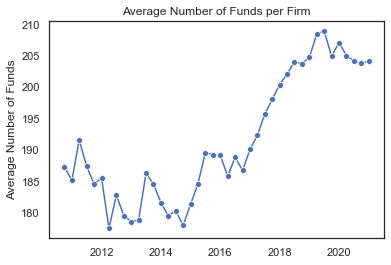

In [157]:
num_funds_df = own_df1.groupby(['sedol', 'asof_date']).count()[['pct']].reset_index()

sns.set()
sns.set_style("white")
p = sns.lineplot(num_funds_df.groupby(['asof_date']).mean().index, num_funds_df.groupby(['asof_date']).mean()['pct'], marker='o')
p.set_title('Average Number of Funds per Firm')
p.set_ylabel('Average Number of Funds')
p.set_xlabel('')
plt.savefig(PATH+"images/coverage.png", bbox_inches="tight", dpi=300)
plt.show()

c:\users\jackl\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


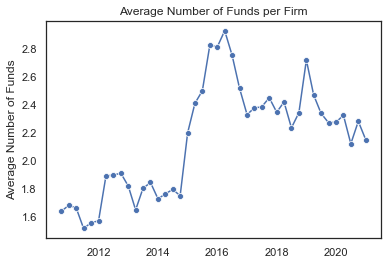

In [162]:
short_df = own_df1[own_df1['short_dummy']==1]
num_funds_df = short_df.groupby(['sedol', 'asof_date']).count()[['pct']].reset_index()
sns.set()
sns.set_style("white")
p = sns.lineplot(num_funds_df.groupby(['asof_date']).mean().index, num_funds_df.groupby(['asof_date']).mean()['pct'], marker='o')
p.set_title('Average Number of Funds per Firm')
p.set_ylabel('Average Number of Funds')
p.set_xlabel('')
plt.savefig(PATH+"images/coverage_short.png", bbox_inches="tight", dpi=300)
plt.show()